# Phishing dataset
### What to test
##### For all methods:
- Metric: precision, accuracy
- holdout, cross-Validation (mean)

##### Methods:
- kNN(2-5), L1 and L2 norm
- Random forest (num trees = ???) (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier) https://mljar.com/blog/how-many-trees-in-random-forest/
 - naive bayes (https://scikit-learn.org/stable/modules/classes.html?highlight=naive%20bayes#module-sklearn.naive_bayes)
    
 ### Structure
 One function to get training + test sets depending on holdout or cross-validation <br>
 One function to train and test for all data splits for a given model <br>
     *Returns (mean) precision, accuracy for holdout/ cross-validation. <br>
     
 One cell for each method

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axis as axis
import time

import sklearn as skl
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.naive_bayes import CategoricalNB

#load data, shuffle and separate parameters from labels
df_raw = pd.read_csv("data/phpV5QYya.csv")
df_shuffeled = df_raw.sample(frac=1,random_state=193520285)
scaler = skl.preprocessing.MinMaxScaler()
scaler.fit(df_shuffeled)
df_shuffeled = scaler.transform(df_shuffeled)

X = df_shuffeled[:,:-1]
Y = df_shuffeled[:,-1:]

#Create splits
cross_validator10 = skl.model_selection.StratifiedKFold(n_splits=10)
hX_train, hX_test, hY_train, hY_test = skl.model_selection.train_test_split(X,Y, test_size=0.2)

## Prepare evaluation functions 

In [70]:
def evaluateModelFromDataset(model, X_train, Y_train, X_test, Y_test):
    start = time.time()
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    delta = (time.time()-start)/len(Y_test)*1000
    
    report = skl.metrics.classification_report(Y_test,Y_pred, output_dict=True)
    
    #Reports precision of phishing links, total accuracy and the time delta fitting and classifying took per test sample (ms)
    return report['1.0']['precision'], report['accuracy'], delta

def evaluateModel(model, do_print = True):

    #Test holdout
    holdout_rep = evaluateModelFromDataset(model, hX_train, hY_train.flatten(), hX_test, hY_test)
    
    #Test cross-evaluation
    report_precision = []
    report_accuracy  = []
    report_time = []
    for train_index, test_index in cross_validator10.split(X,Y):
        X_train = X[train_index]
        Y_train = Y[train_index]
        X_test  = X[test_index]
        Y_test  = Y[test_index]
        
        rep = evaluateModelFromDataset(model, X_train, Y_train.flatten(), X_test, Y_test)
        report_precision.append(rep[0])
        report_accuracy.append(rep[1])
        report_time.append(rep[2])
    
    if(do_print):
        print(f"Holdout precision: {holdout_rep[0]}, accuracy: {holdout_rep[1]}")
        print(f"Cross-evaluation average precision: {np.mean(report_precision)}, std: {np.std(report_precision)}")
        print(f"Cross-evaluation average accuracy: {np.mean(report_accuracy)}, std: {np.std(report_accuracy)}")
        print(f"Holdout time: {holdout_rep[2]}, cross-evaluation mean time: {np.mean(report_time)}")
    return [holdout_rep[0], np.mean(report_precision)], [holdout_rep[1], np.mean(report_accuracy)], [holdout_rep[2], np.mean(report_time)]

## kNN

In [71]:
# perform kNN for different norms and k's

precisions = []
accuracies = []
times = []
ks = range(2,6)
for k in ks:
    kNN_L1 = kNN(n_neighbors=k, p=1)
    kNN_L2 = kNN(n_neighbors=k, p=2)
    
    print(f"-- k={k}, L1 --")
    repL1 = evaluateModel(kNN_L1)
    
    print(f"-- k={k}, L2 --")
    repL2 = evaluateModel(kNN_L2)
    
    precisions.append(repL1[0] + repL2[0])
    accuracies.append(repL1[1] + repL2[1])
    times.append(repL1[2] + repL2[2])
    


-- k=2, L1 --
Holdout precision: 0.9697224558452481, accuracy: 0.9488919041157847
Cross-evaluation average precision: 0.9765457624604489, std: 0.003104173758146621
Cross-evaluation average accuracy: 0.9577572762308428, std: 0.006444423509748466
Holdout time: 0.2202595159081192, cross-evaluation mean time: 0.2311136065461689
-- k=2, L2 --
Holdout precision: 0.9676320272572402, accuracy: 0.9402985074626866
Cross-evaluation average precision: 0.9763750476628271, std: 0.003986868023437379
Cross-evaluation average accuracy: 0.9498877369837906, std: 0.004833689603970898
Holdout time: 0.13025892853790796, cross-evaluation mean time: 0.14056435418552496
-- k=3, L1 --
Holdout precision: 0.9559294871794872, accuracy: 0.95838986883763
Cross-evaluation average precision: 0.9551594972656204, std: 0.004244937334269767
Cross-evaluation average accuracy: 0.9589330922242315, std: 0.00444778876962642
Holdout time: 0.20759691215111412, cross-evaluation mean time: 0.23309948057845603
-- k=3, L2 --
Holdout

<Figure size 432x288 with 0 Axes>

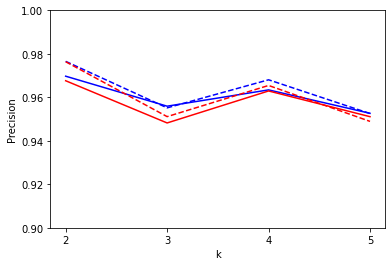

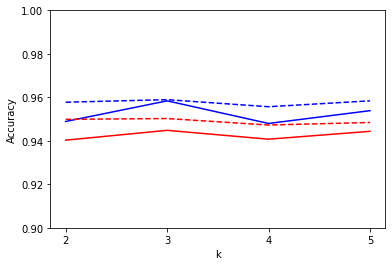

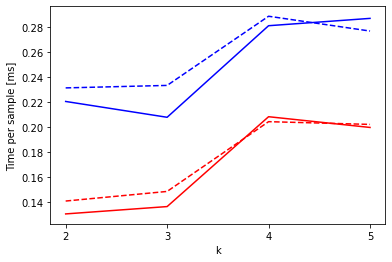

In [72]:
# plot kNN-findings

precisionsT = np.transpose(precisions)
accuraciesT = np.transpose(accuracies)
timesT = np.transpose(times)

#order: holdout L1, cross L1, holdout L2, cross L2
colorScheme = ['b-','b--','r-', 'r--']

plt.figure(0)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(precisionsT)):
    plt.plot(ks, precisionsT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Precision')

plt.ylim([0.9,1])

plt.savefig("ex1-plots/phishing/kNNprecision.png")

plt.figure(1)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(accuraciesT)):
    plt.plot(ks, accuraciesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Accuracy')

plt.ylim([0.9,1])

plt.savefig("ex1-plots/phishing/kNNaccuracy")

plt.figure(2)
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

for i in range(len(timesT)):
    plt.plot(ks, timesT[i],colorScheme[i]) 

plt.xlabel('k')
plt.ylabel('Time per sample [ms]')

plt.savefig("ex1-plots/phishing/kNNtime")




## Naive bayes

In [73]:
# calculate bayes
bayes = CategoricalNB()

evaluateModel(bayes)

Holdout precision: 0.9146537842190016, accuracy: 0.9095431931252826
Cross-evaluation average precision: 0.9170655523882723, std: 0.008394278320478805
Cross-evaluation average accuracy: 0.9059251470792796, std: 0.006118563558773836
Holdout time: 0.008140522557003689, cross-evaluation mean time: 0.017275611099475768


([0.9146537842190016, 0.9170655523882723],
 [0.9095431931252826, 0.9059251470792796],
 [0.008140522557003689, 0.017275611099475768])

In [13]:
# plot bayes

## Random forest

In [7]:
# calculate random forest for different number of forests/ different split measurements

In [8]:
# plot random forest